## Bla bla bla

In [18]:
# !/usr/bin/python

import cv2
import numpy as np
import os

import pandas as pd
import csv

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

nome_pasta = "fig"
mindtct_path = "./mindtct"
nome_pasta_saida = "output"

lista_nome_imagens = []
lista_filtro_imagens = []
lista_numero_minucias = []


Imagem, limiar...

In [19]:
def save_many_thresholds(image_path):
	img = cv2.imread(image_path, 0)
	
	ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
	cv2.imwrite(image_path[:-4]+'[BINA].png',thresh1)
	
	ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
	cv2.imwrite(image_path[:-4]+'[BINV].png',thresh2)
	
	ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
	cv2.imwrite(image_path[:-4]+'[TRUC].png',thresh3)
	
	ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
	cv2.imwrite(image_path[:-4]+'[TZER].png',thresh4)
	
	ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
	cv2.imwrite(image_path[:-4]+'[TOZI].png',thresh5)

NBIS....

In [20]:
def min_to_minutiae_number(min_file):
	f = open(min_file)
	# use readline() to read the first line 
	line = f.readline()
	c = 1
	while line:
	    line = f.readline()
	    c = c + 1
	    if(c == 3):
	    	quantidade_minucias = line
	    	break
	f.close()
	return int(quantidade_minucias.split()[0])

Segmentacao de imagens

In [21]:
for root, dirs, files in os.walk(nome_pasta, topdown=False):
   	for name in files:
   		save_many_thresholds(str(os.path.join(root, name)))

Detecção de minucias

In [22]:
for root, dirs, files in os.walk(nome_pasta, topdown=False):
   	for name in files:
   		command = ' '.join([str(mindtct_path), '-m1', str(os.path.join(root, name)), str(os.path.join(nome_pasta_saida, name))])
   		os.system(command)

Limpa

In [23]:
for root, dirs, files in os.walk(nome_pasta_saida, topdown=False):
   	for name in files:
   		if name.endswith('.min'):
   			#print(min_to_minutiae_number(os.path.join(root, name)))
   			lista_nome_imagens.append(name)
   			if('[BINA].png' in name):
   				lista_filtro_imagens.append('Binary')
   			elif('[BINV].png' in name):
   				lista_filtro_imagens.append('Binary Invert')
   			elif('[TRUC].png' in name):
   				lista_filtro_imagens.append('Trunc')
   			elif('[TZER].png' in name):
   				lista_filtro_imagens.append('Thresh to Zero')
   			elif('[TOZI].png' in name):
   				lista_filtro_imagens.append('Thresh to Zero Invert')
   			else:
			   	lista_filtro_imagens.append('Normal')			
   			lista_numero_minucias.append(min_to_minutiae_number(os.path.join(root, name)))
   		else:
   			os.remove(os.path.join(root, name))

Dataframes

(124, 3)
filtro
Binary                    55.833333
Binary Invert             56.166667
Normal                   118.000000
Thresh to Zero            57.750000
Thresh to Zero Invert     66.000000
Trunc                     97.375000
Name: minucias, dtype: float64


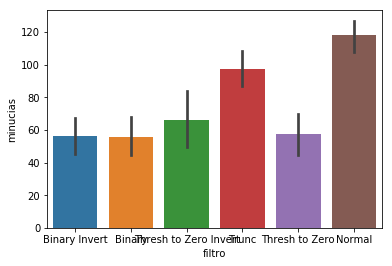

In [24]:
columns = ['nome','filtro','minucias']

df = pd.DataFrame(columns=columns)

df['nome'] = lista_nome_imagens
df['filtro'] = lista_filtro_imagens
df['minucias'] = lista_numero_minucias
df.to_csv('data_frame.csv')

print(df.shape)
print(df.groupby(['filtro', 'nome'], as_index=True).mean().groupby('filtro')['minucias'].mean())

sns.barplot('filtro', 'minucias', data=df, ci=68)
plt.show()